In [1]:
import findspark
findspark.init()

In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import explode
import  matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import udf
from io import BytesIO
import seaborn as sns
%matplotlib inline

In [91]:
spark = SparkSession.builder.appName("Demo example of plot").getOrCreate()
sc = spark.sparkContext

In [92]:
df = spark.read.json(r"./tweets_data.json")
df.createOrReplaceTempView("tweet_table")
users = df.select("user.*").dropDuplicates(subset=['id'])
users.createOrReplaceTempView("user")
entities = df.select("entities.*")
entities.createOrReplaceTempView("entity")
retweeted = df.select("retweeted_status.*")
retweeted.createOrReplaceTempView("user_retweeted")

### Query to fetch top 20 trending hashtags

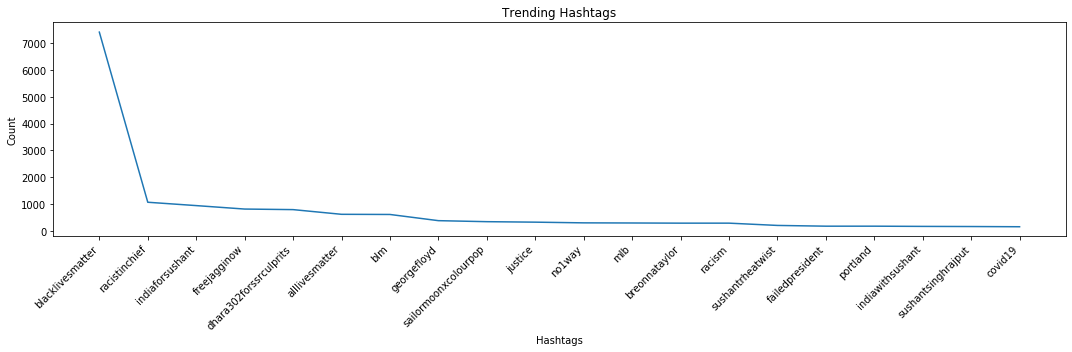

In [166]:
query1 = spark.sql(
        "SELECT LOWER(hashtags.text) As Hashtags, COUNT(*) AS total_count FROM tweet_table LATERAL VIEW EXPLODE(entities.hashtags) AS hashtags GROUP BY LOWER(hashtags.text) ORDER BY total_count DESC LIMIT 20")
pd = query1.toPandas()
pd
plt.plot(pd.Hashtags.tolist(), pd.total_count.tolist())
plt.xticks(rotation=45, ha="right")
plt.title("Trending Hashtags")
plt.xlabel('Hashtags')
plt.ylabel('Count')
# plt.axis('equal')
plt.tight_layout()
pd.to_csv('Query1.csv', index=False)
plt.savefig('query1.png')

### Query to fetch 20 most influential person based on retweeted count

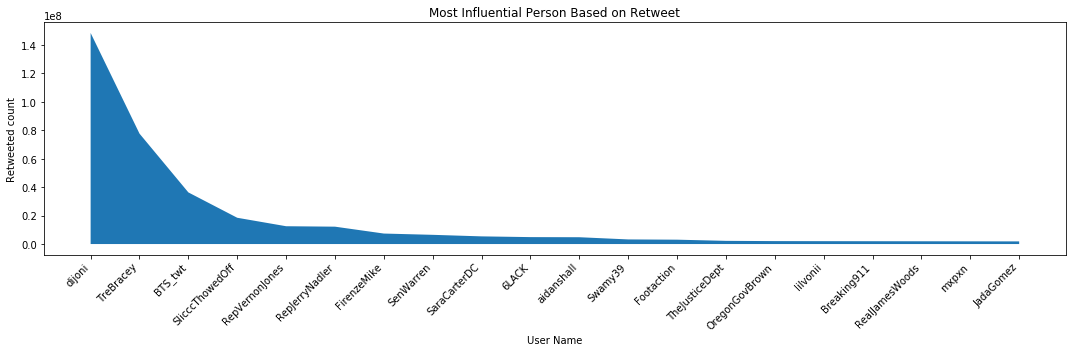

In [167]:
query2 = spark.sql(
        "select  t.Name,t.Retweeted_Count from(select user.screen_name as Name,SUM(retweet_count) as Retweeted_Count, count(*) from user_retweeted where user.screen_name is not null group by Name ) t order by Retweeted_Count DESC LIMIT 20")
pd = query2.toPandas()
x = pd.Name.tolist()
y = pd.Retweeted_Count.tolist()
plt.stackplot(x, y)
plt.title("Most Influential Person Based on Retweet")
plt.xlabel('User Name')
plt.ylabel('Retweeted count')
plt.xticks(rotation=45, ha="right")
# plt.axis('equal')
plt.tight_layout()
pd.to_csv('Query2.csv', index=False)
plt.savefig('query2.png')

### Top 10 Countries based on tweets posted

In [172]:
query3 = spark.sql("select place.country,count(*) As Count from tweet_table where place.country is not null GROUP BY place.country ORDER BY count "
                  "DESC limit 10")

pd_query3 = query3.toPandas()
pd_query3.to_csv('Query3.csv', index=False)
pd_query3

,country,Count
0,United States,616
1,United Kingdom,86
2,India,26
3,Canada,20
4,Côte d'Ivoire,18
5,France,17
6,South Africa,13
7,Nigeria,9
8,Australia,8
9,New Zealand,5


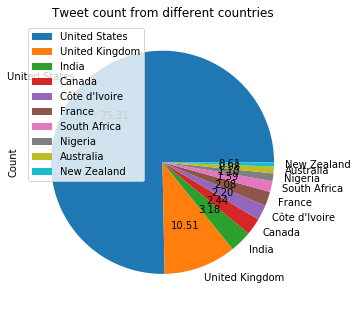

In [174]:
pd_query3.plot.pie(y='Count',labels=pd_query3.country.values.tolist(),figsize=(5,10),autopct='%.2f',title="Tweet count from different countries")
plt.savefig('query3-1.png')

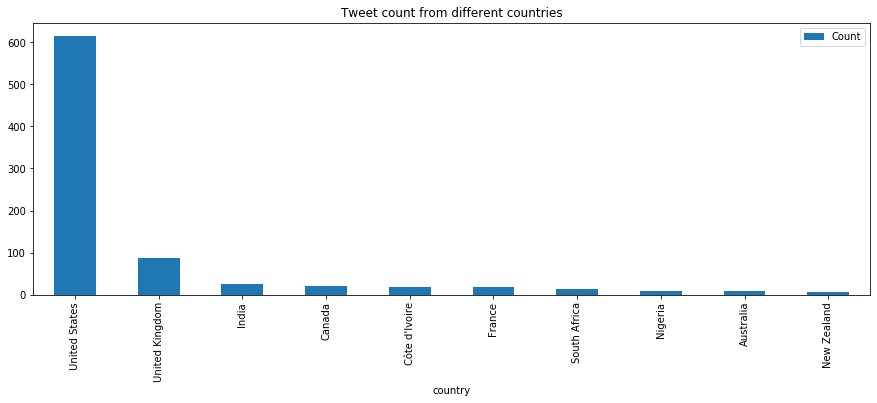

In [175]:
pd_query3.plot.bar(x="country",y="Count",title="Tweet count from different countries")
plt.savefig('query3-2.png')

### Executing a query and retrive the information regarding Tweets based on the different location in USA

In [181]:
query4 = spark.sql("select user.location,count(text) as tweet_count from tweet_table where place.country='United States'and "
                   "user.location is not null Group By user.location ORDER BY tweet_count DESC LIMIT 15")

In [182]:
pd_query4 = query4.toPandas()
pd_query4.to_csv('Query4.csv', index=False)
pd_query4

,location,tweet_count
0,Nevada,13
1,"Los Angeles, CA",9
2,"New York, NY",9
3,"Washington, DC",7
4,"Pittsburgh, PA",6
5,"Chicago, IL",6
6,United States,6
7,"Charlotte, NC",5
8,"Dallas, TX",5
9,Los Angeles,5


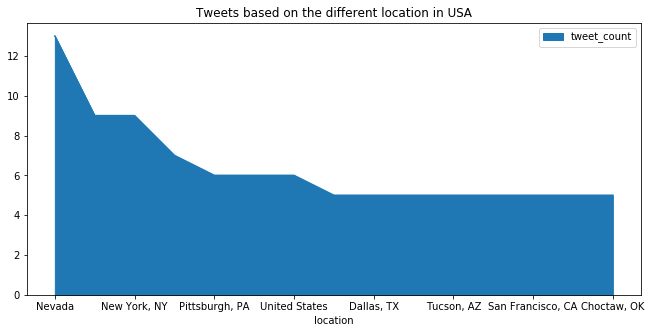

In [183]:
pd_query4.plot.area(x = "location",y="tweet_count",title="Tweets based on the different location in USA",figsize=(11,5))
plt.savefig('query4.png')

### Retrive the information regarding Tweets based on the different tags

In [107]:
query5 = spark.sql("select count(*) as count,q.text from (select case when text like '%BlackLivesMatter%' then 'BlackLivesMatter' when "
                  " text like '%AllLivesMatter%' then 'AllLivesMatter' when text like '%GeorgeFloyd%' then 'GeorgeFloyd' when text"
                  " like '%JusticeForGeorgeFloyd%' then 'JusticeForGeorgeFloyd' when text like '%Justice%' then 'Justice' when text like '%Racism%' "
                  " then 'Racism'"
                  " end as text from "
                  " tweet_table)q group by q.text")

In [184]:
pd_query5 = query5.toPandas()
pd_query5.to_csv('Query5.csv', index=False)
pd_query5

,count,text
0,114187,None
1,6883,BlackLivesMatter
2,3729,Racism
3,571,AllLivesMatter
4,16199,Justice
5,260,GeorgeFloyd


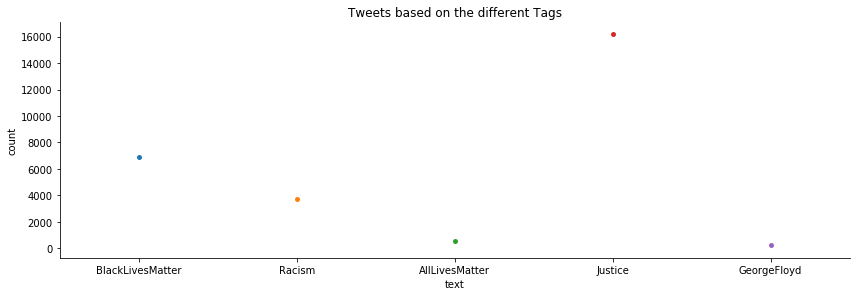

In [185]:
sns.catplot(x="text", y="count",kind="swarm", data=pd_query5.dropna(),height=4,aspect=3)
plt.title("Tweets based on the different Tags")
plt.savefig('query5.png')

### Query to fetch number of tweets per day

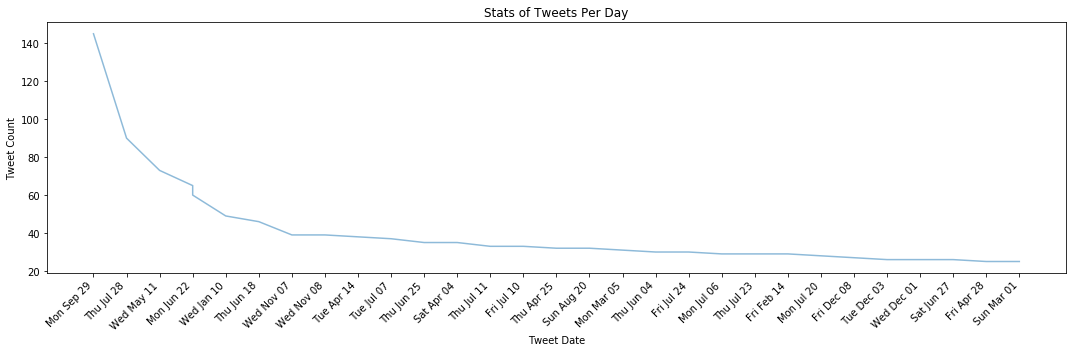

In [186]:
query_6 = spark.sql(
        "select count(*) as TweetCount,SUBSTR(user.created_at,0,10) as TWEETDATE from tweet_table where created_at IS not null GROUP BY user.created_at ORDER BY TweetCount DESC LIMIT 30")
pd = query_6.toPandas()
y = pd.TweetCount.tolist()
x = pd.TWEETDATE.tolist()
pd.to_csv('Query6.csv', index=False)
plt.plot(x, y, alpha=0.5)
plt.title("Stats of Tweets Per Day")
plt.xlabel('Tweet Date')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha="right")
# plt.axis('equal')
plt.tight_layout()
plt.savefig('query6.png')

### Query to fetch top 10 followers based on location

In [187]:
query_7 = spark.sql(
        "select screen_name as Name, location as Location, followers_count as FollowersCount  from user  where location is not null ORDER BY followers_count DESC LIMIT 10")
pd = query_7.toPandas()
pd.to_csv('Query7.csv', index=False)

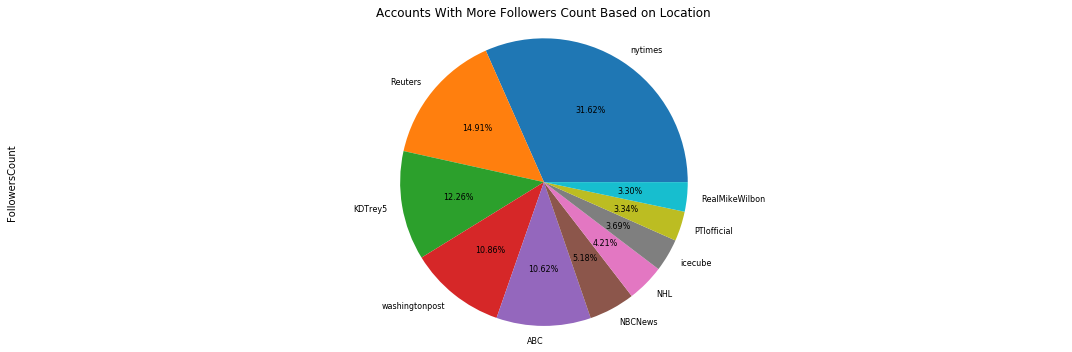

In [188]:
pd.plot.pie(y="FollowersCount", labels=pd.Name.tolist(), autopct='%1.2f%%', shadow=False, legend=False, fontsize=8)
plt.title("Accounts With More Followers Count Based on Location")
plt.axis('equal')
plt.tight_layout()
plt.savefig('query7.png')

### Query to fetch maximum length tweet string based on keywords from text tag

In [189]:
q1 = spark.sql(
        "select 'BlackLivesMatter' as keyword, count(*) as Count from tweet_table where text like '%BlackLivesMatter%'")
q2 = spark.sql(
        "select 'GeorgeFloyd' as keyword, count(*) as Count from tweet_table where text like '%GeorgeFloyd%'")
q3 = spark.sql(
        "select 'Racism' as keyword , count(*) as Count from tweet_table where text like '%Racism%'")
query_8 = q1.union(q2).union(q3)
pd = query_8.toPandas()
pd.to_csv('Query8.csv', index=False)

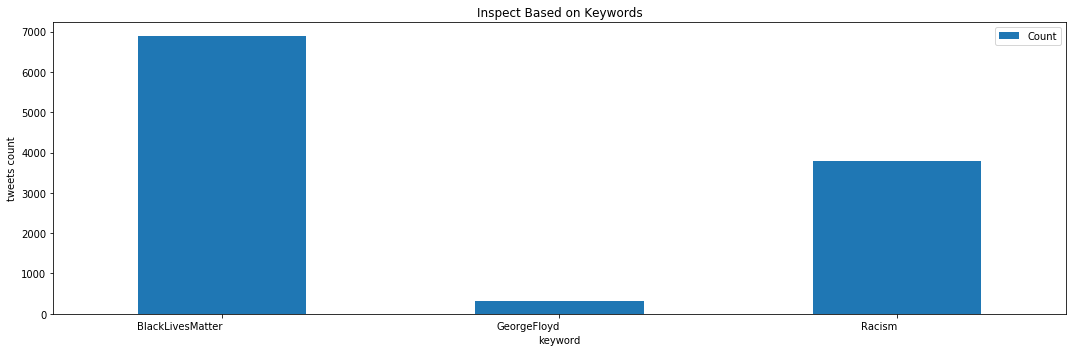

In [190]:
pd.set_index("keyword", drop=True, inplace=True)
pd.plot.bar()
plt.xticks(rotation=0, ha="right")
plt.title("Inspect Based on Keywords")
plt.ylabel('tweets count')
# plt.axis('equal')
plt.tight_layout()
# plt.show()
plt.savefig('query8.png')

### Query to fetch users geo location enabled: true or false

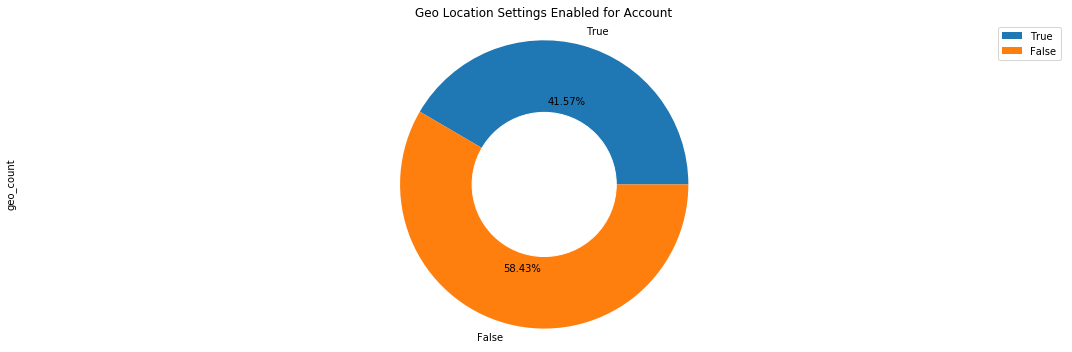

In [191]:
query_9 = spark.sql(
        "select sum(geo_count) as geo_count,geo_enabled from (select count(*) as geo_count,geo_enabled from user where geo_enabled is not null group by geo_enabled union select count(*) as geo_count,user.geo_enabled as geo_enabled from user_retweeted where user.geo_enabled is not null group by user.geo_enabled) group by geo_enabled")
pd = query_9.toPandas()
pd.to_csv('Query9.csv', index=False)
pd.plot.pie(y="geo_count", labels=pd.geo_enabled.tolist(), autopct='%1.2f%%', fontsize=10)
my_circle = plt.Circle((0, 0), 0.5, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Geo Location Settings Enabled for Account")
plt.axis('equal')
plt.tight_layout()
plt.savefig('query9.png')

### Query to get most mentioned twitter accounts

C:\Users\garik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\garik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12511 missing from current font.
  font.set_text(s, 0, flags=flags)


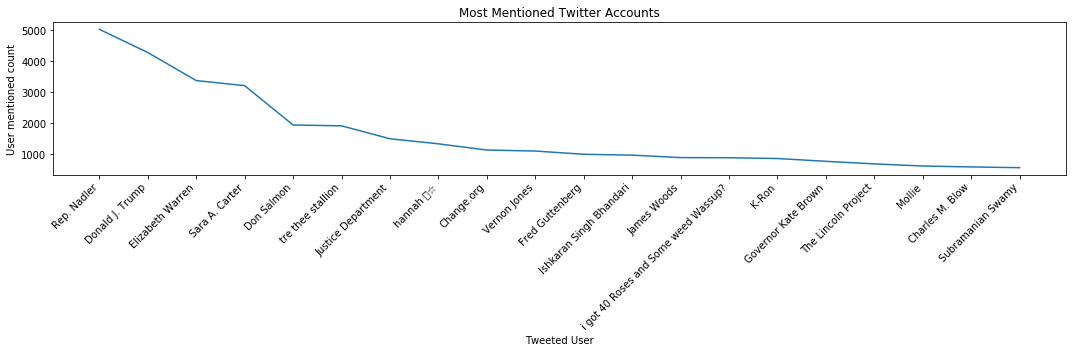

In [192]:
query_10 = spark.sql(
        "select usermention, count(*) as value from entity lateral view explode(entity.user_mentions.name) as usermention group by usermention order by value desc limit 20")
pd = query_10.toPandas()
pd.to_csv('Query10.csv', index=False)
matplotlib.rcParams['figure.figsize'] = 15, 5
x = pd.usermention.tolist()
y = pd.value.tolist()
plt.plot(x, y)
plt.title("Most Mentioned Twitter Accounts")
plt.xlabel('Tweeted User')
plt.ylabel('User mentioned count')
plt.xticks(rotation=45, ha="right")
# plt.axis('equal')
plt.tight_layout()
plt.savefig('Query10.png')

### Retrive the information regarding On which Day More Tweets are posted (Weekday & Weekend)

In [193]:
day_data = spark.sql("SELECT substring(user.created_at,1,3) as day from tweet_table where text is not null")
day_data.createOrReplaceTempView("day_data")

days_final = spark.sql(
          """ SELECT Case
            when day LIKE '%Mon%' then 'WEEKDAY'
            when day LIKE '%Tue%' then 'WEEKDAY'
            when day LIKE '%Wed%' then 'WEEKDAY'
            when day LIKE '%Thu%' then 'WEEKDAY'
            when day LIKE '%Fri%' then 'WEEKDAY'
            when day LIKE '%Sat%' then 'WEEKEND'
            when day LIKE '%Sun%' then 'WEEKEND'
             else
             null
             end as day1 from day_data where day is not null""")
days_final.createOrReplaceTempView("days_final")
query11 = spark.sql("SELECT day1 as Day,Count(*) as Day_Count from days_final where day1 is not null group by day1 order by count(*) desc")

In [194]:
pd_query11 = query11.toPandas()
pd_query11.to_csv('Query11.csv', index=False)
pd_query11

,Day,Day_Count
0,WEEKDAY,103689
1,WEEKEND,38139


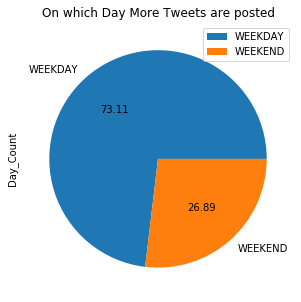

In [197]:
pd_query11.plot.pie(y="Day_Count",labels=pd_query11.Day.tolist(),autopct='%.2f',title="On which Day More Tweets are posted")
plt.savefig('Query11.png')

### Top 10 users with more number of retweets

In [198]:
query12 = spark.sql("select user.name,retweeted_status.text as Retweet_Text,retweeted_status.retweet_count as Retweet_Count from tweet_table where retweeted_status.retweet_count is not null order by retweeted_status.retweet_count desc limit 10")

In [199]:
pd_query12 = query12.toPandas()
pd_query12.to_csv('Query12.csv', index=False)
pd_query12

,name,Retweet_Text,Retweet_Count
0,Army,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931541
1,Aila ⁷ 💜,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931537
2,im roller coaster come ride me bby grill,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931537
3,Yasmin Valeriano,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931533
4,ᴠᴀɴᴛᴇ៹⁷ִֶָ 🥢,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931532
5,monse♡ˎˊ🇦🇷||🏳️‍🌈,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931532
6,Ale💜,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931532
7,Dam Dam,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931532
8,Hio 💜,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931531
9,Enza🦋,"우리는 인종차별에 반대합니다.\n우리는 폭력에 반대합니다.\n나, 당신, 우리 모두...",931530


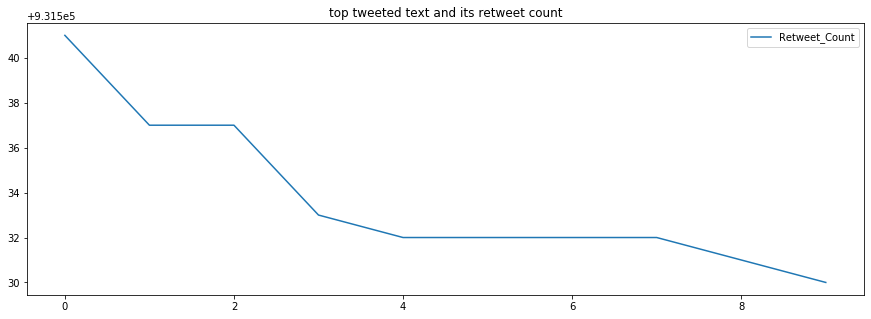

In [200]:
# pd_query2.plot.bar(x="name",y="Retweet_Count",title="User with more tweets for his tweets")
pd_query2.plot(title="top tweeted text and its retweet count")
plt.savefig('Query12.png')